In [28]:
pip install qutip

Note: you may need to restart the kernel to use updated packages.


In [29]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from qutip.qip.operations import *
np.set_printoptions(precision = 3)

In [30]:
# spin operators
X = sigmax()
Y = sigmay()
Z = sigmaz()
I = qeye(2)

II = tensor(I, I)

IX = tensor(X, I)
IY = tensor(Y, I)
IZ = tensor(Z, I)

SX = tensor(I, X)
SY = tensor(I, Y)
SZ = tensor(I, Z)

IZSZ = tensor(Z, Z) # J coupling

In [31]:
R = lambda state, angle: (state * -1j * angle).expm()

Ix = lambda angle: R(IX / 2, angle)
Sx = lambda angle: R(SX / 2, angle)
IxSx = lambda angle: R((IX + SX) / 2, angle)

Iy = lambda angle: R(IY / 2, angle)
Sy = lambda angle: R(SY / 2, angle)
IySy = lambda angle: R((IY + SY) / 2, angle)

# in theory we could do Iz and Sz
Iz = lambda angle: R(IZ / 2, angle)
Sz = lambda angle: R(SZ / 2, angle)

# but we cannot pulse on Z in NMR in the same way
# so we do a composite of X and Y pulse
Iz_composite = lambda angle: Ix(np.pi/2) * Iy(angle) * Ix(-np.pi/2)
Sz_composite = lambda angle: Sx(np.pi/2) * Sy(angle) * Sx(-np.pi/2)
IzSz = lambda angle: R(IZSZ / 4, angle)

SyIx = lambda angle: R((SY +IX) / 2, angle)
SxIy = lambda angle: R((SX +IY) / 2, angle)

**Pulse Sequence Phases (3rd Param)**\
+x = 0\
+y = 1\
-x = 2\
-y = 3

In [100]:
global_imag_phase = np.exp(-1j * np.pi / 2)
global_neg_phase = np.exp(-1j * np.pi)

### Bit Flip

Pulse Sequence for 1H: 
`pulse(1, a90H, 0, d180H)`\
Pulse Sequence for 13C:
`pulse(2, a90C, 0, d180C)`\
Pulse Sequence for both:
`pulse(1, a90HC, 0, freq1H, 2, a90C, 0, freq13C, d180C)`

In [101]:
def bitflip_operator(qubit):
    if qubit == "1H":
        return Ix(-np.pi) * global_imag_phase
    elif qubit == "13C":
        return Sx(-np.pi)  * global_imag_phase
    elif qubit == "both":
        return IxSx(-np.pi) * global_neg_phase
    else: 
        print(f"Invalid qubit for bitflip. Do nothing.")
        return II

In [102]:
print(bitflip_operator('1H') ) 
print(bitflip_operator('13C'))
print(bitflip_operator('both') )

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


### Hadamard

Pulse Sequence for 1H:

`pulse(1, a90H, 0, d180H)`\
`delay(0.25)`\
`pulse(1, a90H, 1, d90H)`

Pulse Sequence for 13C:

`pulse(2, a90C, 0, d180C)`\
`delay(0.25)`\
`pulse(2, a90C, 1, d180C)`


Pulse Sequence for both:

`pulse(1, a90HC, 0, freq1H, 2, a90C, 0, freq13, d180C)`\
`delay(0.25)`\
`pulse(1, a90HC, 1, freq1H, 2, a90C, 1, freq13, d90C)`

In [113]:
def hadamard_operator(qubit):
    if qubit == "1H":
        return Ix(np.pi) * Iy(np.pi/2) * global_imag_phase * global_neg_phase
    
    elif qubit == "13C":
        return Sx(np.pi) * Sy(np.pi/2) * global_imag_phase * global_neg_phase

    elif qubit == "both":
        return IxSx(np.pi) * IySy(np.pi/2) * global_neg_phase
    
    else: 
        print(f"Invalid qubit for Hadamard. Do nothing.")
        return II

In [112]:
print(np.sqrt(2) * hadamard_operator('1H'))
print(np.sqrt(2) * hadamard_operator('13C'))
print(2 * hadamard_operator('both'))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-1.  0. -1.  0.]
 [ 0. -1.  0. -1.]
 [-1.  0.  1.  0.]
 [ 0. -1.  0.  1.]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-1. -1.  0.  0.]
 [-1.  1.  0.  0.]
 [ 0.  0. -1. -1.]
 [ 0.  0. -1.  1.]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  1.  1.  1.]
 [ 1. -1.  1. -1.]
 [ 1.  1. -1. -1.]
 [ 1. -1. -1.  1.]]


### CZ

Composite Iz pulse on NMR:

`pulse(1, a90H, 0, d90H)`\
`delay(0.25)`\
`pulse(1, a90H, 1, d90H)`\
`delay(0.25)`\
`pulse(1, d90H, 2, d90H)`\
`delay(0.25)`

Composite Sz pulse on NMR:\
`pulse(2, a90C, 0, d90C)`\
`delay(0.25)`\
`pulse(2, a90C, 1, d90C)`\
`delay(0.25)`\
`pulse(2, a90C, 2, d90C)`

In [92]:
def CZ_operator(NMR=True):
    global_phase = np.exp(1j * np.pi / 4)
    if NMR:
        return Iz_composite(np.pi/2) * Sz_composite(np.pi/2) * IzSz(-np.pi) * global_phase
    else:
        return Iz(np.pi/2) * Sz(np.pi/2) * IzSz(-np.pi)

In [94]:
print(CZ_operator())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]


#### CNOT

Pulse Sequence for Approximate CNOT:

`pulse(2, a90C, 0, d90C)` \
`delay(dEvolution)` \
`pulse(2, a90C, 1, d90C)`

Pulse Sequence for Actual CNOT:

`pulse(2, a90C, 1, d45C)`\
`delay(0.25)`\
`pulse(2, a90C, 0, d180C)`\
`delay(0.25)`\
`pulse(2, a90C, 3, d45C)`\
`delay(0.25)`

`pulse(1, a90H, 2, d90H)`\
`delay(0.25)`\
`pulse(1, a90H, 1, d90H)`\
`delay(0.25)`\
`pulse(1, a90H, 0, d90H)` \
`delay(0.25)`

`pulse(2, a90C, 2, d90C)`\
`delay(0.25)`\
`pulse(2, a90C, 1, d90C)`\
`delay(0.25)`\
`pulse(2, a90C, 0, d90C)`

`delay(dEvolution)`

`pulse(2, a90C, 1, d45C)`\
`delay(0.25)`\
`pulse(2, a90C, 0, d180C)`\
`delay(0.25)`\
`pulse(2, a90C, 3, d45C)`



In [38]:
def CNOT_operator(approx=False):
    if not approx: 
        return hadamard_operator('13C') * CZ_operator() * hadamard_operator('13C')  * -global_phase
    else:
        return Sz(-np.pi/2) * Sx(np.pi/2) * IzSz(np.pi) * Sy(np.pi/2) * Iz(np.pi/2) * global_phase

In [39]:
print(CNOT_operator(approx=False))
print(CNOT_operator(approx=True))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


#### Lets plot the expected spectra for each of these gates on our NMR system

In [40]:
# rho thermal (not including 1/4 I)
rho = Qobj([[5,0,0,0],
            [0,3,0,0],
            [0,0,-3,0],
            [0,0,0,-5]], dims = [[2,2], [2,2]])

In [41]:
def plot_spectra(rho, gate, label=""):
  evolved_rho = gate * rho * gate.dag()

  a = np.array(evolved_rho)[0,0]
  b = np.array(evolved_rho)[1,1]
  c = np.array(evolved_rho)[2,2]
  d = np.array(evolved_rho)[3,3]

  x = ['1H peak 2', '1H peak 1', '13C peak 2', '13C peak 1']
  y = [b-d, a-c, c-d, a-b]

  plt.bar(x, y)
  plt.xlabel('Frequency')
  plt.ylabel('Signal Amplitude')
  plt.grid(True)
  plt.title(label)
  plt.show()

/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/codespace/.local/lib/python3.10/site-packages/matplotlib/transforms.py:766: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


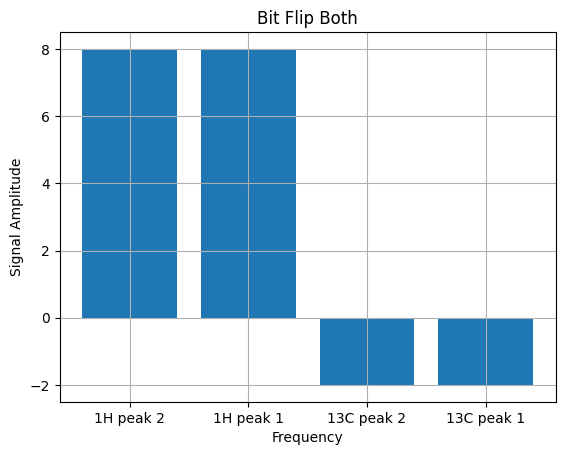

In [42]:
plot_spectra(rho, bitflip_operator('13C'), "Bit Flip Both")

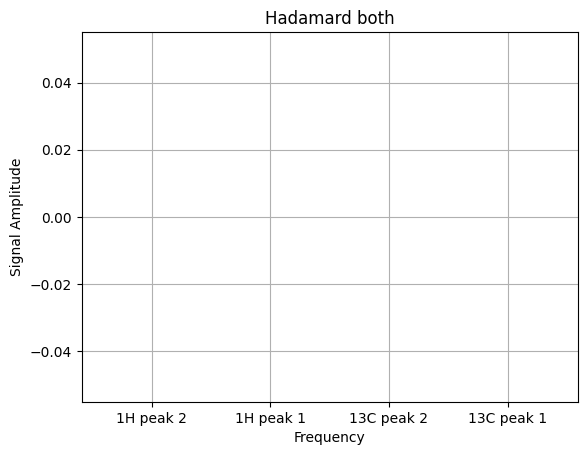

In [43]:
plot_spectra(rho, hadamard_operator('both'), "Hadamard both")

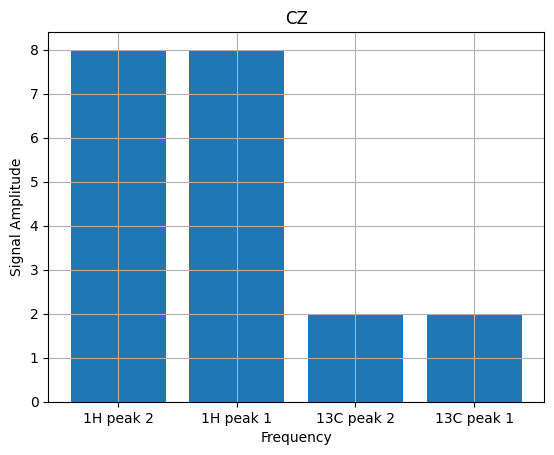

In [44]:
plot_spectra(rho, CZ_operator(), "CZ")

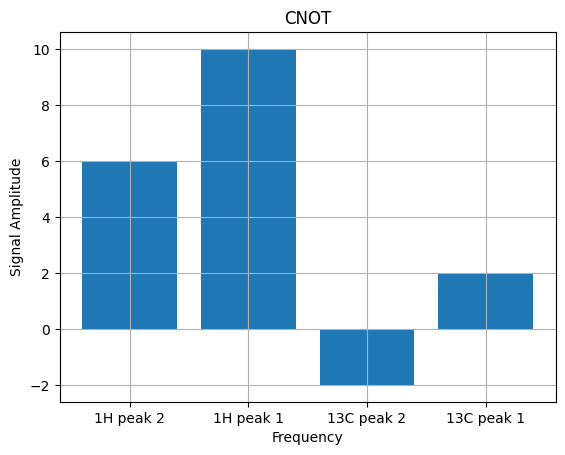

In [45]:
plot_spectra(rho, CNOT_operator(), "CNOT")

f(x) = 0: Always outputs 0, regardless of the input.\
f(x) = 1: Always outputs 1, regardless of the input.\
f(x) = x: Outputs whatever the input is.\
f(x) = NOT x: If the input is 0, the output is 1, and vice versa.

Classically we would implement the functions as follows:

In [46]:
def f1(x):
    return 0
def f2(x):
    return 1
def f3(x):
    return x
def f4(x):
    return 1 if x == 0 else 0

In [47]:
def U(f):
  if f == 0:
    return II
  if f == 1:
    return bitflip_operator('13C')
  if f == 2:
    return CNOT_operator()
  if f == 3:
    return CNOT_operator() * bitflip_operator('13C')
  

U0 = (hadamard_operator('13C') * U(0) * hadamard_operator('13C'))
U1 = (hadamard_operator('13C') * U(1) * hadamard_operator('13C'))
U2 = (hadamard_operator('13C') * U(2) * hadamard_operator('13C'))
U3 = (hadamard_operator('13C') * U(3) * hadamard_operator('13C'))


print(U(0) * global_neg_phase)
print(U(1) * global_imag_phase * global_neg_phase)
print(U(2) * global_neg_phase)
print(U(3) * global_imag_phase * global_neg_phase)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0. -1.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0. -1.  0.]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0. -1.  0.]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0. -1.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]


#### Deutsch Jozsa
We have all of the oracles for DJ algorithm defined above. We also need to do temporal averaging.

In [48]:
def deutsch_josza(oracle):
    # constant functions
    if oracle == 'U0':
        return hadamard_operator('both') * U(0) * hadamard_operator('both')
    if oracle == 'U1':
        return hadamard_operator('both') * U(1) * hadamard_operator('both')
    # balanced functions
    if oracle == 'U2':
        return hadamard_operator('both') * U(2) * hadamard_operator('both')
    if oracle == 'U3':
        return hadamard_operator('both') * U(3) * hadamard_operator('both')
 

In [106]:
def temporal_average(rho):
    P0 = II # do nothing 
    P1 = Sx(np.pi/2) * IzSz(np.pi) * SyIx(np.pi/2) * IzSz(np.pi) * Iy(np.pi/2)
    P2 = Ix(np.pi/2) * IzSz(np.pi) * SxIy(np.pi/2) * IzSz(np.pi) * Sy(np.pi/2)

    rho0 = P0 * rho * P0.dag()
    rho1 = P1 * rho * P1.dag()
    rho2 = P2 * rho * P2.dag()
    
    return (rho0 + rho1 + rho2)/3 + (5/3 * II)

def apply_gate_tmp_avg(rho, gate, state='00'):
    if state == '00':
        bitflip = II
    if state == '01':
        bitflip = bitflip_operator('13C')
    if state == '10':
        bitflip = bitflip_operator('1H')
    if state == '11':
        bitflip = bitflip_operator('both')
    

    rho_tmp_avg = temporal_average(rho)
    rho_state = bitflip * rho_tmp_avg * bitflip.dag()
    rho_gate_applied = gate * rho_state * gate.dag()

    return rho_gate_applied

In [107]:
# print (apply_gate_tmp_avg(rho, deutsch_josza('U0'), '00'))
# print (apply_gate_tmp_avg(rho, deutsch_josza('U1'), '00'))
# print (apply_gate_tmp_avg(rho, deutsch_josza('U2'), '00'))
# print (apply_gate_tmp_avg(rho, deutsch_josza('U3'), '00'))
print (apply_gate_tmp_avg(rho, deutsch_josza('U0'), '01'))
print (apply_gate_tmp_avg(rho, deutsch_josza('U1'), '01'))
print (apply_gate_tmp_avg(rho, deutsch_josza('U2'), '01'))
print (apply_gate_tmp_avg(rho, deutsch_josza('U3'), '01'))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.    0.    0.    0.   ]
 [0.    6.667 0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.    0.    0.    0.   ]
 [0.    6.667 0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    6.667]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    6.667]]


#### Grover's Algorithm

$$ G = H^{\otimes 2}PH^{\otimes 2}O. $$
Where we define oracle, O, as the phase flip operator:
$$
O = R_{y1}R_{x1}R_{y1}R_{y2}R_{x2}R_{y2}\tau
$$
$$
O = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{bmatrix}
$$

and P:
$$
P = R_{y1}R_{x1}R_{y1}R_{y2}R_{x2}R_{y2}\tau
$$
$$
P = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & -1
\end{bmatrix}
$$




In [141]:
def grover(U, state):
    
    H = hadamard_operator('both')

    flipboth = bitflip_operator('both')
    if state == '00':
        P = bitflip_operator('both') * CZ_operator() * bitflip_operator('both')
    if state == '01':
        P = bitflip_operator('1H') * CZ_operator()* bitflip_operator('1H')
    if state == '10':
        P = bitflip_operator('13C') * CZ_operator()* bitflip_operator('13C')
    if state == '11':
        P = CZ_operator()

    G =  H * U * H * P * H 

    return G

oracle = CZ_operator()


In [143]:
print (apply_gate_tmp_avg(rho, grover(oracle, '00'), '00'))
print (apply_gate_tmp_avg(rho, grover(oracle, '01'), '00'))
print (apply_gate_tmp_avg(rho, grover(oracle, '10'), '00'))
print (apply_gate_tmp_avg(rho, grover(oracle, '11'), '00'))


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    6.667]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    6.667 0.   ]
 [0.    0.    0.    0.   ]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.    0.    0.    0.   ]
 [0.    6.667 0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[6.667 0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]
